In [276]:
from pathlib import Path
import sys

helper_utils = Path.cwd() / "utils"
sys.path.append(str(helper_utils))

import utils 
import shutil
import random
import torch
from PIL import Image
from sklearn.model_selection import train_test_split

In [277]:
data_path = Path.cwd() / "datasets"
dataset_path = utils.download_dataset("historical cracks",
                                   dest_path=data_path,
                                   extract=True)

Downloading:
Historical-crack18-19: A dataset of annotated images for non-invasive surface crack detection in historical buildings
> Authors: Esraa Elhariri, Nashwa El-Bendary, Shereen Taie
> Year: 2020
> Website: https://www.sciencedirect.com/science/article/pii/S2352340922000774#fig0001

File already exists


Extracting Historical Building Cracks.zip: 100%|██████████| 3899/3899 [00:01<00:00, 2245.20it/s]


In [278]:
main_data_path = list(dataset_path.glob("*"))[0]
images = list(main_data_path.rglob("*.jpg"))

In [279]:
rnd_ix = random.randint(0, len(images) - 1)
img = Image.open(images[rnd_ix])
img.size

(256, 256)

(128, 128)


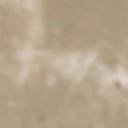

In [280]:
img = img.resize((128, 128))
print(img.size)
img

(100, 100)


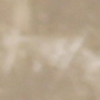

In [281]:
img_ctr_x = img.size[0] // 2
img_ctr_y = img.size[1] // 2

cropped = img.crop((img_ctr_x - 50, img_ctr_y - 50, img_ctr_x + 50, img_ctr_y + 50))
print(cropped.size)
cropped

In [282]:
from torchvision import transforms

ts = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.CenterCrop((100, 100)),
    transforms.ToTensor(),
])

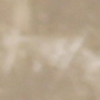

In [283]:
img_tensor = ts(img)
img_tensor.shape

# display the tensor as an image with PIL
img_tensor_pil = transforms.ToPILImage()(img_tensor)
img_tensor_pil

# Resizing the images

In [284]:
# Resize the images in the folders to 512x512
# utils.resize_images_in_folder(images, (256, 256))

In [285]:
img_crack = main_data_path / "crack"
img_no_crack = main_data_path / "non-crack"

# The no crack images are not balanced with the crack images
# Let's balance them by taking a random sample of the no crack images
crack_images = list(img_crack.glob("*.jpg"))
no_crack_images = list(img_no_crack.glob("*.jpg"))
no_crack_images = random.sample(no_crack_images, len(crack_images))

len(crack_images), len(no_crack_images)


(757, 757)

In [286]:
# Create a new folder for the balanced dataset
balanced_data_path = main_data_path / "balanced"
balanced_data_path.mkdir(parents=True, exist_ok=True)
crack_folder = balanced_data_path / "crack"
crack_folder.mkdir(parents=True, exist_ok=True)
no_crack_folder = balanced_data_path / "no_crack"
no_crack_folder.mkdir(parents=True, exist_ok=True)
# Copy the crack images to the balanced folder
for img in crack_images:
    shutil.copy(img, crack_folder / img.name)
# Copy the no crack images to the balanced folder
for img in no_crack_images:
    shutil.copy(img, no_crack_folder / img.name)


In [287]:
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder

ts = transforms.Compose([
    transforms.Resize((64, 64)),
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

torch.manual_seed(42)
data = ImageFolder(balanced_data_path, transform=ts)
train_ds, val_ds, test_ds = random_split(data, [0.5, 0.25, 0.25])

In [288]:
data.classes

['crack', 'no_crack']

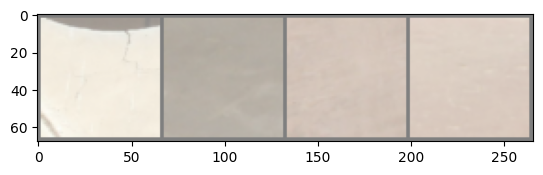

tensor([0, 1, 1, 1])


In [289]:
# visualize the first image in the dataset
import matplotlib.pyplot as plt
import torchvision
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
train_loader = DataLoader(val_ds, batch_size=4, shuffle=True)
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(labels)

In [290]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

In [291]:
images[0].max(), images[0].min()

(tensor(0.9922), tensor(0.1059))

In [292]:
class simpleCNN(torch.nn.Module):
    def __init__(self, n_classes):
        super(simpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(64 * 64 * 64, 128)
        self.fc2 = torch.nn.Linear(128, n_classes)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = x.view(-1, 64 * 64 * 64)  # Flatten the tensor
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_v1 = simpleCNN(len(data.classes))
criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model_v1.parameters(), lr=5e-3)
num_epochs = 25

simpleCNN Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

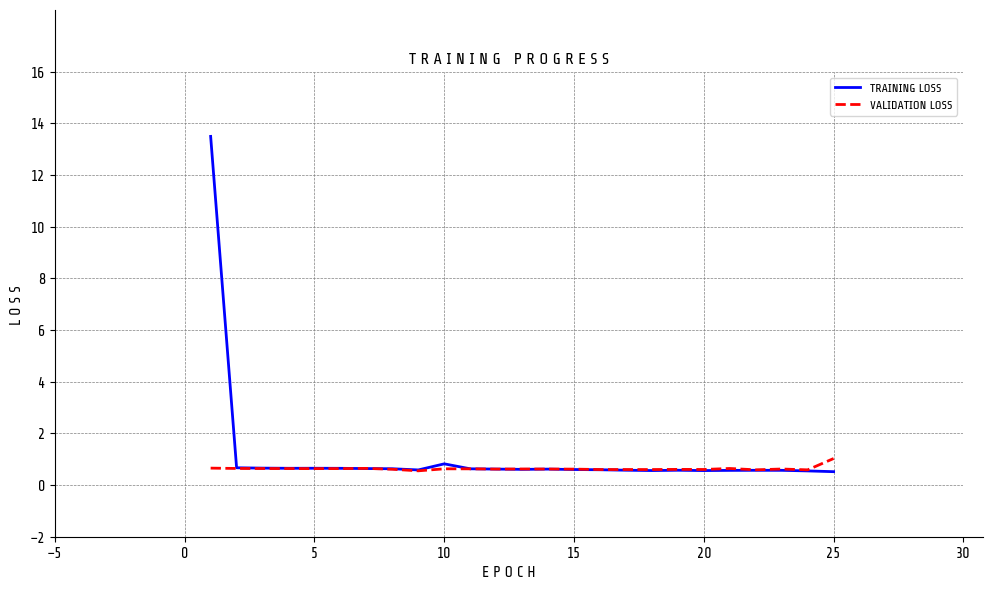

In [293]:
model_v1 = utils.train_model(model_v1,
                             criterion,
                             optimiser,
                             train_loader=train_dl,
                             val_loader=val_dl,
                             num_epochs=num_epochs,
                             plot_loss=True)

In [294]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_v1.eval()
with torch.no_grad():
    for images, labels in test_dl:
        outputs = model_v1(images.to(device))
        print(outputs[:-1])
        _, predicted = torch.max(outputs, 1)
        print(predicted)
        break

tensor([[-5.4129e-01,  7.8675e-01],
        [-5.8705e-01,  9.0607e-01],
        [-2.8808e-01,  8.6451e-01],
        [-6.7995e-01,  1.2741e+00],
        [-4.8188e-01,  7.3625e-01],
        [-6.8722e-01,  1.0198e+00],
        [-6.8311e-01,  9.6356e-01],
        [-2.6822e+00,  5.1111e+00],
        [-6.0734e-01,  8.7422e-01],
        [-5.8636e-01,  1.7167e+00],
        [-1.8910e+00,  3.9386e+00],
        [-6.8724e-01,  1.7324e+00],
        [-4.6947e-01,  8.4175e-01],
        [-3.6819e-01,  1.3494e+00],
        [-6.3606e-01,  9.3014e-01],
        [-2.2298e+00,  4.5164e+00],
        [-6.3636e-01,  9.2649e-01],
        [ 4.9674e-03,  4.9335e-01],
        [-5.4631e-01,  7.9794e-01],
        [-5.3092e-01,  7.8323e-01],
        [-6.2211e-01,  2.6648e+00],
        [-5.2595e-01,  7.6683e-01],
        [-1.0765e+00,  1.4242e+00],
        [-5.1913e-01,  7.7456e-01],
        [-4.7463e-01,  7.1413e-01],
        [-3.2642e+00,  6.2389e+00],
        [-6.8736e-01,  1.6749e+00],
        [-9.0180e-01,  1.628

In [295]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_accuracy(model, test_dataloader):
    model.eval()
    acc = 0.0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device).type(torch.long)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            acc += utils.accuracy_score(labels, predicted)

    return acc / len(test_dataloader)

compute_accuracy(model_v1, test_dl)

0.6697916666666667

In [296]:
from sklearn.metrics import classification_report, confusion_matrix

test_labels = []
test_preds = []

model_v1.eval()
with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device).type(torch.long)
        outputs = model_v1(images)
        _, predicted = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())
print(classification_report(test_labels, test_preds, target_names=data.classes))

              precision    recall  f1-score   support

       crack       0.94      0.09      0.16       190
    no_crack       0.66      1.00      0.79       332

    accuracy                           0.67       522
   macro avg       0.80      0.54      0.48       522
weighted avg       0.76      0.67      0.56       522



## Regularisation methods
When using convolutional neural networks, we can use regularisation methods to prevent overfitting and to stabilise the training process. The most common regularisation methods are:
- **Dropout**: Randomly sets a fraction of input units to 0 at each update during training time, which helps prevent overfitting.
- **L2 regularisation**: Adds a penalty on the size of the weights to the loss function. This is also known as weight decay.
- **Batch Normalisation**: Normalises the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation. This helps to stabilise the learning process and can lead to faster convergence.
- **Data augmentation**: Increases the diversity of the training set by applying random transformations to the input data, such as rotation, translation, and scaling. This helps to improve the generalisation of the model.

In [308]:
class regularizedCNN(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        # Reduced number of filters in conv layers
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.flat = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(64 * 32 * 32, 512)
        self.fc2 = torch.nn.Linear(512, n_classes)
        # Keep dropout for regularization
        self.dropout = torch.nn.Dropout(p=0.2)
        # Keep batch normalization for more stable training
        self.batch_norm1 = torch.nn.BatchNorm2d(64)
        
    def forward(self, x):
        x = self.pool1(torch.nn.functional.relu(self.batch_norm1(self.conv1(x))))
        x = self.flat(x)
        x = self.dropout(torch.nn.functional.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [323]:
model_v2 = regularizedCNN(len(data.classes))
criterion_reg = torch.nn.CrossEntropyLoss()
optimiser_reg = torch.optim.Adam(model_v2.parameters(),
                                 lr=5e-4,
                                 weight_decay=7.5e-5)  # L2 regularization (weight decay)
num_epochs_reg = 25

regularizedCNN Training:   0%|          | 0/25 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Training Batch 0/17:   0%|          | 0/17 [00:00<?, ?it/s]

Validation Batch 0/9:   0%|          | 0/9 [00:00<?, ?it/s]

Early stopping at epoch 11


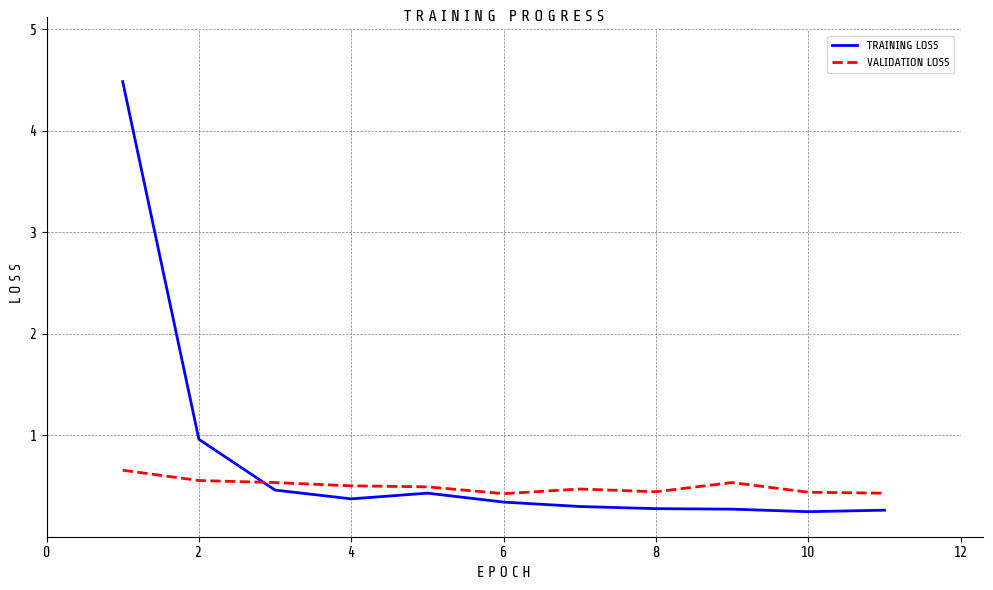

In [324]:
model_v2 = utils.train_model(model_v2,
                  criterion_reg,
                  optimiser_reg,
                  train_loader=train_dl,
                  val_loader=val_dl,
                  num_epochs=num_epochs_reg,
                  early_stopping=True,
                  patience=5,
                  plot_loss=True)

In [325]:
compute_accuracy(model_v2, test_dl)

0.8343750000000001

In [326]:
from sklearn.metrics import classification_report, confusion_matrix

test_labels = []
test_preds = []

model_v2.eval()
with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device).type(torch.long)
        outputs = model_v2(images)
        _, predicted = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())
print(classification_report(test_labels, test_preds, target_names=data.classes))

              precision    recall  f1-score   support

       crack       0.75      0.80      0.77       190
    no_crack       0.88      0.84      0.86       332

    accuracy                           0.83       522
   macro avg       0.81      0.82      0.82       522
weighted avg       0.83      0.83      0.83       522

